# New Section

# New Section

In [1]:
!pwd

/content


In [2]:
%cd /content/drive/MyDrive/style transfer

/content/drive/MyDrive/style transfer


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

tf.compat.v1.enable_eager_execution()

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image

import time
import functools

In [4]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [5]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [6]:
#content_path = tf.keras.utils.get_file('YellowLabradorLooking_new.jpg', 'https://storage.googleapis.com/download.tensorflow.org/example_images/YellowLabradorLooking_new.jpg')

# https://commons.wikimedia.org/wiki/File:Vassily_Kandinsky,_1913_-_Composition_7.jpg
#style_path = tf.keras.utils.get_file('kandinsky5.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg')

In [7]:
content_path = 'rashmika-mandannahd-wallpapers-desktop-background-android-iphone-1080p-4k-4na5b-1000x1500.jpg'
style_path = '/content/drive/MyDrive/style transfer/3837.png'

In [8]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

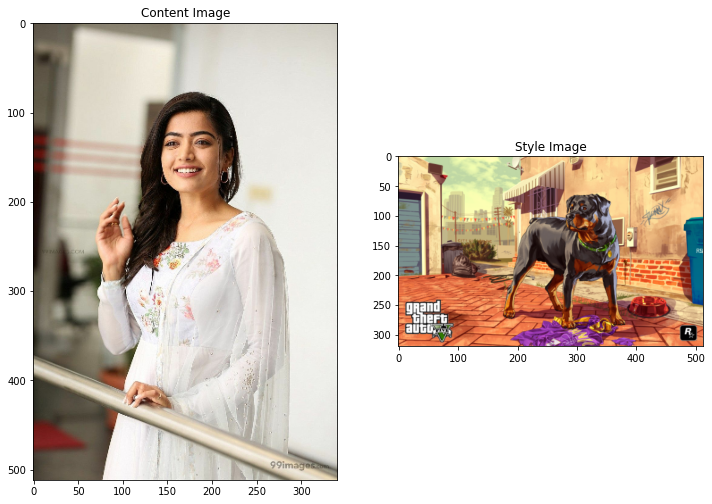

In [9]:
content_image = load_img(content_path)
style_image = load_img(style_path)

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

In [10]:
mobnet = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')

print()
for layer in mobnet.layers:
  print(layer.name)

17612800/17605208 [==============================] - 0s 0us/step

input_1
rescaling
Conv
Conv/BatchNorm
tf.__operators__.add
re_lu
tf.math.multiply
multiply
expanded_conv/depthwise
expanded_conv/depthwise/BatchNorm
re_lu_1
expanded_conv/project
expanded_conv/project/BatchNorm
expanded_conv/Add
expanded_conv_1/expand
expanded_conv_1/expand/BatchNorm
re_lu_2
expanded_conv_1/depthwise/pad
expanded_conv_1/depthwise
expanded_conv_1/depthwise/BatchNorm
re_lu_3
expanded_conv_1/project
expanded_conv_1/project/BatchNorm
expanded_conv_2/expand
expanded_conv_2/expand/BatchNorm
re_lu_4
expanded_conv_2/depthwise
expanded_conv_2/depthwise/BatchNorm
re_lu_5
expanded_conv_2/project
expanded_conv_2/project/BatchNorm
expanded_conv_2/Add
expanded_conv_3/expand
expanded_conv_3/expand/BatchNorm
re_lu_6
expanded_conv_3/depthwise/pad
expanded_conv_3/depthwise
expanded_conv_3/depthwise/BatchNorm
re_lu_7
expanded_conv_3/squeeze_excite/AvgPool
reshape
expanded_conv_3/squeeze_excite/Conv
expanded_conv_3/squeeze_

In [11]:
# Content layer where will pull our feature maps
content_layers = ['expanded_conv_13/expand/BatchNorm'] 

# Style layer of interest
style_layers = ['expanded_conv_8/expand/BatchNorm',
                'expanded_conv_9/expand/BatchNorm',
                'expanded_conv_10/expand/BatchNorm', 
                'expanded_conv_11/expand/BatchNorm', 
                'expanded_conv_12/expand/BatchNorm']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [12]:
def mobnet_layers(layer_names):
  """ Creates a mobnet model that returns a list of intermediate output values."""
  mobnet = tf.keras.applications.MobileNetV3Large(include_top=False, weights='imagenet')
  mobnet.trainable = False
  
  outputs = [mobnet.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([mobnet.input], outputs)
  return model

In [13]:
style_extractor = mobnet_layers(style_layers)
style_outputs = style_extractor(style_image*255)

for name, output in zip(style_layers, style_outputs):
  print(name)
  print("  shape: ", output.numpy().shape)
  print("  min: ", output.numpy().min())
  print("  max: ", output.numpy().max())
  print("  mean: ", output.numpy().mean())
  print()

expanded_conv_8/expand/BatchNorm
  shape:  (1, 20, 32, 184)
  min:  -10.476856
  max:  13.631411
  mean:  0.49260694

expanded_conv_9/expand/BatchNorm
  shape:  (1, 20, 32, 184)
  min:  -15.1400585
  max:  18.272512
  mean:  0.03429292

expanded_conv_10/expand/BatchNorm
  shape:  (1, 20, 32, 480)
  min:  -27.239578
  max:  18.233452
  mean:  0.5631761

expanded_conv_11/expand/BatchNorm
  shape:  (1, 20, 32, 672)
  min:  -18.996244
  max:  19.478725
  mean:  0.019804789

expanded_conv_12/expand/BatchNorm
  shape:  (1, 20, 32, 672)
  min:  -42.371418
  max:  34.222664
  mean:  -1.074108



In [14]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [15]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.mobnet =  mobnet_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.mobnet.trainable = False

  def call(self, inputs):
    "Expects float input in [0,1]"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.mobilenet_v3.preprocess_input(inputs)
    outputs = self.mobnet(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}
    
    return {'content':content_dict, 'style':style_dict}

In [16]:
extractor = StyleContentModel(style_layers, content_layers)

results = extractor(tf.constant(content_image))

style_results = results['style']

print('Styles:')
for name, output in sorted(results['style'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())
  print()

print("Contents:")
for name, output in sorted(results['content'].items()):
  print("  ", name)
  print("    shape: ", output.numpy().shape)
  print("    min: ", output.numpy().min())
  print("    max: ", output.numpy().max())
  print("    mean: ", output.numpy().mean())

Styles:
   expanded_conv_10/expand/BatchNorm
    shape:  (1, 480, 480)
    min:  -79.98546
    max:  161.11635
    mean:  0.27599195

   expanded_conv_11/expand/BatchNorm
    shape:  (1, 672, 672)
    min:  -25.138193
    max:  38.367973
    mean:  0.014335955

   expanded_conv_12/expand/BatchNorm
    shape:  (1, 672, 672)
    min:  -43.163742
    max:  67.66421
    mean:  1.5338261

   expanded_conv_8/expand/BatchNorm
    shape:  (1, 184, 184)
    min:  -20.701986
    max:  38.19308
    mean:  0.2937297

   expanded_conv_9/expand/BatchNorm
    shape:  (1, 184, 184)
    min:  -16.189602
    max:  25.452177
    mean:  0.012721955

Contents:
   expanded_conv_13/expand/BatchNorm
    shape:  (1, 16, 10, 960)
    min:  -40.899883
    max:  30.565847
    mean:  -0.07904596


In [17]:
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

In [18]:
image = tf.Variable(content_image)  

In [19]:
def clip_0_1(image):
  return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

In [20]:
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

In [21]:
style_weight = 1e6
content_weight = 1

In [22]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

In [23]:
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(clip_0_1(image))

In [ ]:
train_step(image)
train_step(image)
train_step(image)
tensor_to_image(image)

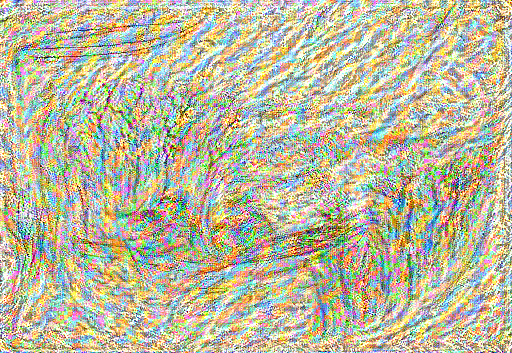

Train step: 50
Total time: 9.5


In [ ]:
import time
start = time.time()

epochs = 50
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='')
  display.clear_output(wait=True)
  display.display(tensor_to_image(image))
  print("Train step: {}".format(step))
  
end = time.time()
print("Total time: {:.1f}".format(end-start))